### Submesoscale Diagnostics Calculations 

This notebook calculates various diagnostic variables from velocity gradients. 

Contains calculations for along track distance, vorticity, divergence, strain rate, vertical velocity, buoyancy, and frontogenic tendency. 

Also looks at rossby radius of deformation, rossby number, froude number, and reynolds number 

### Import packages 

In [1]:
# import utilities (functions I created) 
import sys
sys.path.append("/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/utilities")
from Utils import *
from ATOMIC_Utils import *
from Gradient_LeastSquares import *

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
# import sys
# sys.path.append("/home/mlb15109/Research/ATOMIC/github_repos/ATOMIC_MesoscaleFront/utilities")
# from Utils import *
# from ATOMIC_Utils import *
# from Gradient_LeastSquares import *
import seawater as sw
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import nan_euclidean_distances
from scipy import stats
from pycurrents.adcp.rdiraw import Multiread

### Functions

In [3]:

def CalculateDistance(lon,lat):
    """
    Calculate along-track distance given
        an array of lon,lat.
    Return
        - along-track distance [km]
    """
    return np.hstack([0,np.cumsum(sw.dist(lon=lon,lat=lat,units='km')[0])])

### Load data locally 

In [4]:
allcoefs = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/coefs.nc')
coefs_nonadcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/coefs_nonadcp.nc')
adcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/adcp_reduced.nc')
subset_nonadcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/nonadcp_5min_reduced.nc')


In [5]:
subset_nonadcp

<xarray.Dataset>
Dimensions:            (time: 5992, saildrone: 3)
Coordinates:
    latitude           (time, saildrone) float64 ...
    longitude          (time, saildrone) float64 ...
  * saildrone          (saildrone) float32 1.026e+03 1.06e+03 1.061e+03
  * time               (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-...
Data variables: (12/13)
    UWND_MEAN          (time, saildrone) float64 ...
    UWND_STDDEV        (time, saildrone) float64 ...
    VWND_MEAN          (time, saildrone) float64 ...
    VWND_STDDEV        (time, saildrone) float64 ...
    WWND_MEAN          (time, saildrone) float64 ...
    WWND_STDDEV        (time, saildrone) float64 ...
    ...                 ...
    TEMP_SBE37_STDDEV  (time, saildrone) float64 ...
    SAL_SBE37_MEAN     (time, saildrone) float64 ...
    SAL_SBE37_STDDEV   (time, saildrone) float64 ...
    sigma0             (time, saildrone) float64 ...
    b                  (time, saildrone) float64 ...
    relative_dist      (saildrone, time) float64 ...
Attributes: (12/38)
    title:                     ATOMIC-EUREC4A 2020 Surface Data - 1 min
    summary:                   This data set was collected by three saildrone...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.3
    featureType:               trajectory
    ...                        ...
    geospatial_lat_min:        7.4658584
    geospatial_lat_max:        12.051028
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -59.3422848
    geospatial_lon_max:        -48.5522528
    geospatial_lon_units:      degrees_east

In [6]:
allcoefs

<xarray.Dataset>
Dimensions:    (time: 5982, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-23T04:10:00
  * depth      (depth) float64 4.2 6.2 8.2 10.2 12.2 ... 96.2 98.2 100.2 102.2
    longitude  (time) float64 ...
    latitude   (time) float64 ...
Data variables:
    v_mean     (depth, time) float64 ...
    vx         (depth, time) float64 ...
    vy         (depth, time) float64 ...
    u_mean     (depth, time) float64 ...
    ux         (depth, time) float64 ...
    uy         (depth, time) float64 ...
    e_mean     (depth, time) float64 ...
    ex         (depth, time) float64 ...
    ey         (depth, time) float64 ...

In [7]:
subset = adcp

### Calculate along track distance, vorticity, divergence, and strain rate 

In [8]:
# calculate distance and add to dataset 

ds_list = [allcoefs, coefs_nonadcp]
for ds in ds_list:
    
    distance = CalculateDistance(lon = ds.longitude, lat = ds.latitude)
    ds['distance'] = ('time',distance)

# distance calc for ds with saildrone dimension - wasn't working in loop above 
distance = CalculateDistance(lon = subset_nonadcp.sel(saildrone='1060').longitude, lat = subset_nonadcp.sel(saildrone='1060').latitude)
subset_nonadcp['distance'] = ('time',distance)

# distance calc for ds with saildrone dimension - wasn't working in loop above 
distance = CalculateDistance(lon = subset.sel(saildrone='1060').longitude, lat = subset.sel(saildrone='1060').latitude)
subset['distance'] = ('time',distance)

In [9]:
# calculate normalized vorticity 
vorticity = (allcoefs['vx']-allcoefs['uy'])/gsw.f(allcoefs['latitude'])

# calculate normalized divergence
div = (allcoefs['ux']+allcoefs['vy'])/gsw.f(allcoefs['latitude'])

# calculate strain rate
strain = ((((allcoefs['ux']-allcoefs['vy'])**2)+((allcoefs['uy']+allcoefs['vx'])**2))**0.5)/gsw.f(allcoefs['latitude'])

# add variables to dataset
allcoefs['vort'] = vorticity
allcoefs['div'] = div
allcoefs['strain'] = strain

In [10]:
allcoefs.distance.diff(dim='time').mean()

<xarray.DataArray 'distance' ()>
array(0.472492)

### Calculate vertical velocity from divergence

In [11]:
# define a non-normalized divergence to calculate vertical velocity with 
div_nonnorm = allcoefs.div * gsw.f(allcoefs['latitude'])

In [12]:
# calculate vertical velocity from divergence 
w = []
for j in range(len(div_nonnorm.depth)):
    w.append(-np.trapz(div_nonnorm.isel(depth=slice(0,j)),axis=0,dx=-2))

allcoefs['w'] = (['depth','time'],w)

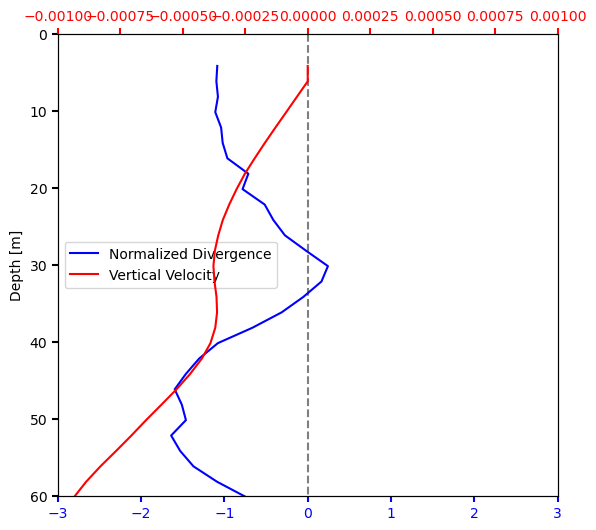

In [13]:
# plot vertical velocity and divergence vertical section
fig, ax = plt.subplots(figsize=(8,6))
fig.subplots_adjust(right=0.75)

twin1 = ax.twiny()


p1, = ax.plot(allcoefs.isel(time=400).div,allcoefs.isel(time=400).depth,"b-",label='Normalized Divergence')
p2, = twin1.plot(allcoefs.isel(time=400).w,allcoefs.isel(time=400).depth,"r-",label='Vertical Velocity')

ax.set_ylim(60,0)
ax.set_ylabel('Depth [m]')
ax.xaxis.label.set_color(p1.get_color())
twin1.xaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='x', colors=p1.get_color(), **tkw)
ax.set_xlim(-3,3)
twin1.tick_params(axis='x', colors=p2.get_color(), **tkw)
twin1.set_xlim(-0.0010,0.0010)
ax.tick_params(axis='y', **tkw)
ax.vlines(ymin=0,ymax=60,x=0,color='k',linestyle='dashed',alpha=0.5)

ax.legend(handles=[p1, p2,],loc='center left')

### Calculate frontogenic tendency 

F = −(uxb2x + vyb2y) − (vx + uy)bxby 

In [14]:
# calculate frontogenic tendency 
F = -(allcoefs.ux * (coefs_nonadcp.bx)**2 + allcoefs.vy * (coefs_nonadcp.by)**2) - (allcoefs.vx + allcoefs.uy)*coefs_nonadcp.bx*coefs_nonadcp.by


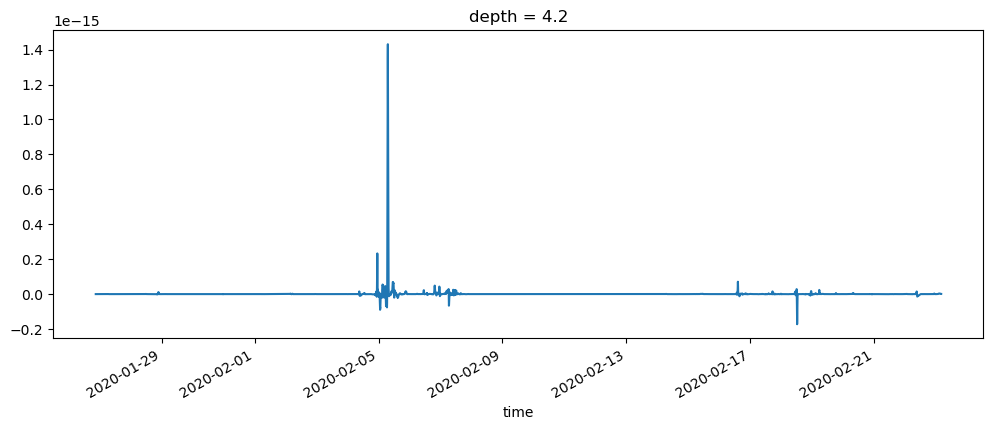

In [15]:
F.isel(depth=0).plot(figsize=(12,4))

In [16]:
# normalize F 

rho_mag = np.sqrt(coefs_nonadcp.rhox**2 + coefs_nonadcp.rhoy**2)
coefs_nonadcp['rho_mag'] = rho_mag

rho_angle = np.arctan2(coefs_nonadcp.rhoy,coefs_nonadcp.rhox)
rho_angle = (rho_angle*180)/np.pi
coefs_nonadcp['rho_angle'] = rho_angle

f = gsw.f(allcoefs['latitude']).mean()
g = 9.81
rho0 = 1025
gradrho_std = np.std(rho_mag)

F2 = (g**2/rho0**2) * (gsw.f(allcoefs['latitude'])) * (gradrho_std)**2

allcoefs['F'] = F / F2

In [17]:
allcoefs

<xarray.Dataset>
Dimensions:    (time: 5982, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-23T04:10:00
  * depth      (depth) float64 4.2 6.2 8.2 10.2 12.2 ... 96.2 98.2 100.2 102.2
    longitude  (time) float64 -51.38 -51.38 -51.38 ... -52.95 -52.95 -52.95
    latitude   (time) float64 7.502 7.502 7.503 7.503 ... 8.719 8.719 8.719
Data variables: (12/15)
    v_mean     (depth, time) float64 ...
    vx         (depth, time) float64 ...
    vy         (depth, time) float64 ...
    u_mean     (depth, time) float64 ...
    ux         (depth, time) float64 ...
    uy         (depth, time) float64 ...
    ...         ...
    distance   (time) float64 0.0 0.113 0.2197 ... 2.826e+03 2.826e+03 2.826e+03
    vort       (depth, time) float64 -0.8507 -0.6818 -0.5367 ... nan nan nan
    div        (depth, time) float64 0.1804 0.8026 0.8702 0.8702 ... nan nan nan
    strain     (depth, time) float64 0.3369 0.4978 0.7402 0.7402 ... nan nan nan
    w          (depth, time) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    F          (depth, time) float64 -0.0001936 -0.0009333 -0.001455 ... nan nan

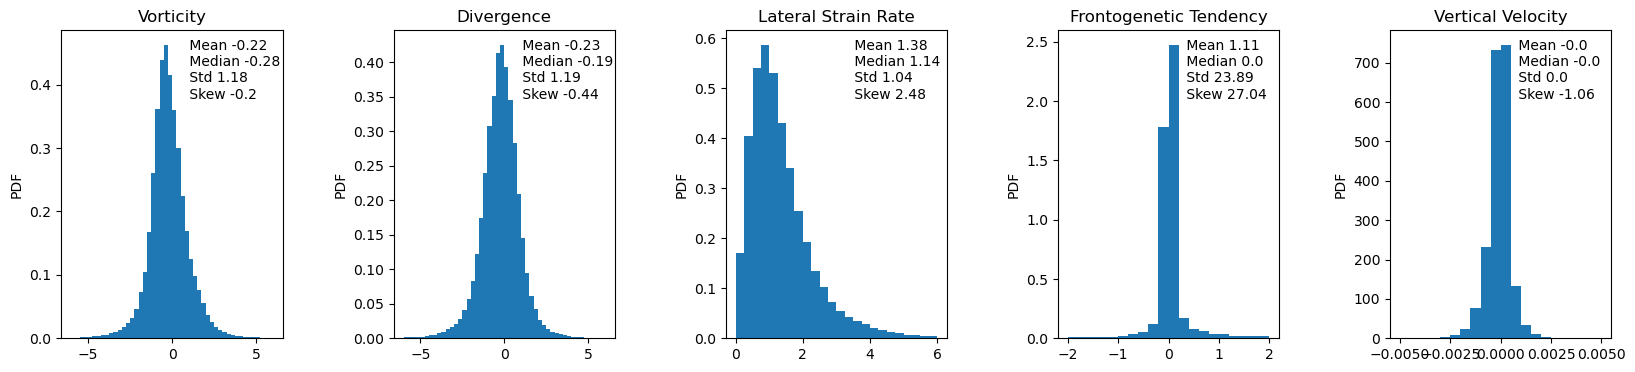

In [18]:
dbins, bmin, bmax = 0.25, -6, 6
fig = plt.figure(figsize=(20,4))
ax0 = fig.add_subplot(151)
ax1 = fig.add_subplot(152)
ax2 = fig.add_subplot(153)
ax3 = fig.add_subplot(154)
ax4 = fig.add_subplot(155)

img0 = ax0.hist(allcoefs.isel(depth=slice(0,24)).vort.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

# # plot normal distribution on top 
# x = np.linspace(bmin, bmax, 100)
# mu = np.nanmean(coefs.vort.values.flatten())
# std = np.nanstd(coefs.vort.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax0.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# # ax0.legend()

img1 = ax1.hist(allcoefs.isel(depth=slice(0,24)).div.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

# # plot normal distribution on top 
# x = np.linspace(bmin, bmax, 100)
# mu = np.nanmean(coefs.div.values.flatten())
# std = np.nanstd(coefs.div.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax1.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# # ax1.legend()


img2 = ax2.hist(allcoefs.isel(depth=slice(0,24)).strain.values.flatten(),density=True,bins=np.arange(0,bmax+dbins,dbins))

bmin = -2
bmax = 2
dbins = 0.2

img3 = ax3.hist(allcoefs.isel(depth=0).F.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

bmin = -0.005
bmax = 0.005
dbins = 0.0005

img4 = ax4.hist(allcoefs.isel(depth=slice(0,24)).w.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))



ax0.set_title('Vorticity')
ax0.set_ylabel('PDF')
ax1.set_title('Divergence')
ax1.set_ylabel('PDF')
ax2.set_title('Lateral Strain Rate')
ax2.set_ylabel('PDF')
ax3.set_title('Frontogenetic Tendency')
ax3.set_ylabel('PDF')
ax4.set_title('Vertical Velocity')
ax4.set_ylabel('PDF')
plt.subplots_adjust(wspace=0.5)

for ax,var in zip([ax0, 
                   ax1, 
                   ax2,
                   ax3,
                   ax4],
                  [allcoefs.isel(depth=slice(0,24)).vort.values.flatten(),
                   allcoefs.isel(depth=slice(0,24)).div.values.flatten(),
                   allcoefs.isel(depth=slice(0,24)).strain.values.flatten(),
                   allcoefs.isel(depth=0).F.values.flatten(),
                   allcoefs.isel(depth=slice(0,24)).w.values.flatten()]):
        ax.text(.56,0.87,
                (f' Mean {get_stats(var)[0]} \n Median {get_stats(var)[1]} \n Std {get_stats(var)[2]} \n Skew {get_stats(var)[3]}'.format()),
        ha='left',va='center',transform=ax.transAxes,fontsize=10)

# plt.savefig('/home/mlb15109/Research/ATOMIC/figures/gradientcalc_sensitivity/RD5_Int10_k2.jpeg',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/figures/paper_figs/FullDS_PDFs_upper50m.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)

In [19]:
vort_skew = np.ones(len(allcoefs.depth))
vort_std = np.ones(len(allcoefs.depth))
for i in range(len(allcoefs.depth)):
    vort_skew[i] = get_stats(allcoefs.vort.isel(depth=i).values.flatten())[3]
    vort_std[i] = get_stats(allcoefs.vort.isel(depth=i).values.flatten())[2]

In [20]:
div_skew = np.ones(len(allcoefs.depth))
div_std = np.ones(len(allcoefs.depth))
for i in range(len(allcoefs.depth)):
    div_skew[i] = get_stats(allcoefs.div.isel(depth=i).values.flatten())[3]
    div_std[i] = get_stats(allcoefs.div.isel(depth=i).values.flatten())[2]

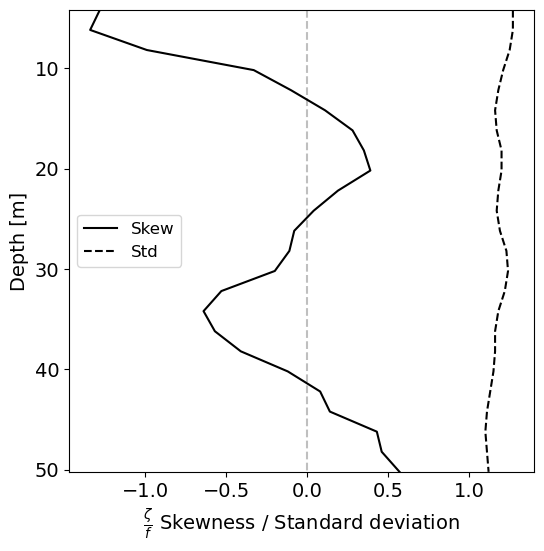

In [21]:
plt.rcParams.update({'font.size': 14})
coefs_subset = allcoefs.isel(depth=slice(0,24))
fig = plt.figure(figsize=(6,6))
plt.plot(vort_skew[0:24],coefs_subset.depth,label='Skew',color='k')
plt.plot(vort_std[0:24],coefs_subset.depth,label='Std',linestyle='dashed',color='k')
# plt.plot(div_skew[0:24],coefs_subset.depth,label='Divergence')
plt.ylim(coefs_subset.depth[-1],coefs_subset.depth[0])
plt.vlines(x=0,ymax=coefs_subset.depth[-1],ymin=coefs_subset.depth[0],linestyle='--',color='grey',alpha=0.5)
plt.ylabel('Depth [m]')
plt.xlabel(r'$\frac{\zeta}{f}$ Skewness / Standard deviation')
plt.legend(loc='center left',fontsize=12)


# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/vort_skew_std.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)
            

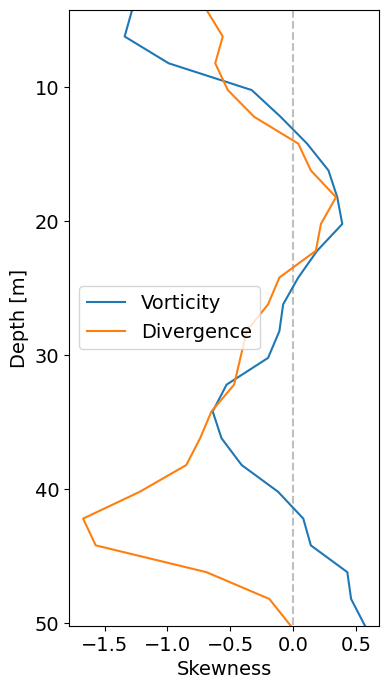

In [22]:
coefs_subset = allcoefs.isel(depth=slice(0,24))
fig = plt.figure(figsize=(4,8))
plt.plot(vort_skew[0:24],coefs_subset.depth,label='Vorticity')
plt.plot(div_skew[0:24],coefs_subset.depth,label='Divergence')
plt.ylim(coefs_subset.depth[-1],coefs_subset.depth[0])
plt.vlines(x=0,ymax=coefs_subset.depth[-1],ymin=coefs_subset.depth[0],linestyle='--',color='grey',alpha=0.5)
plt.ylabel('Depth [m]')
plt.xlabel('Skewness')
plt.legend(loc='center left')

Text(0.5, 0, 'Std')

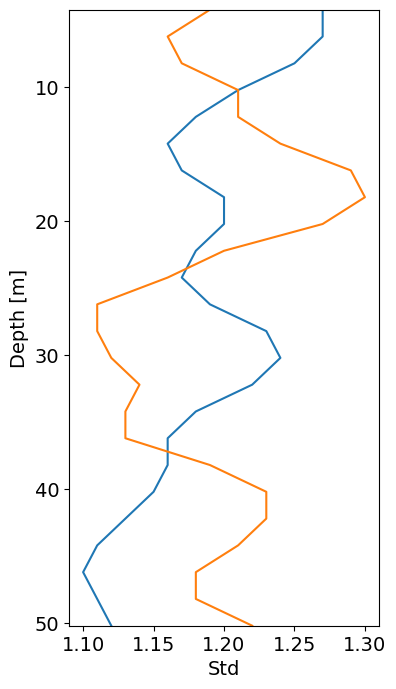

In [23]:
coefs_subset = allcoefs.isel(depth=slice(0,24))
fig = plt.figure(figsize=(4,8))
plt.plot(vort_std[0:24],coefs_subset.depth,label='Vorticity')
plt.plot(div_std[0:24],coefs_subset.depth,label='Divergence')
plt.ylim(coefs_subset.depth[-1],coefs_subset.depth[0])
# plt.vlines(x=0,ymax=coefs_subset.depth[-1],ymin=coefs_subset.depth[0],linestyle='--',color='grey',alpha=0.5)
plt.ylabel('Depth [m]')
plt.xlabel('Std')
# plt.legend(loc='center left')

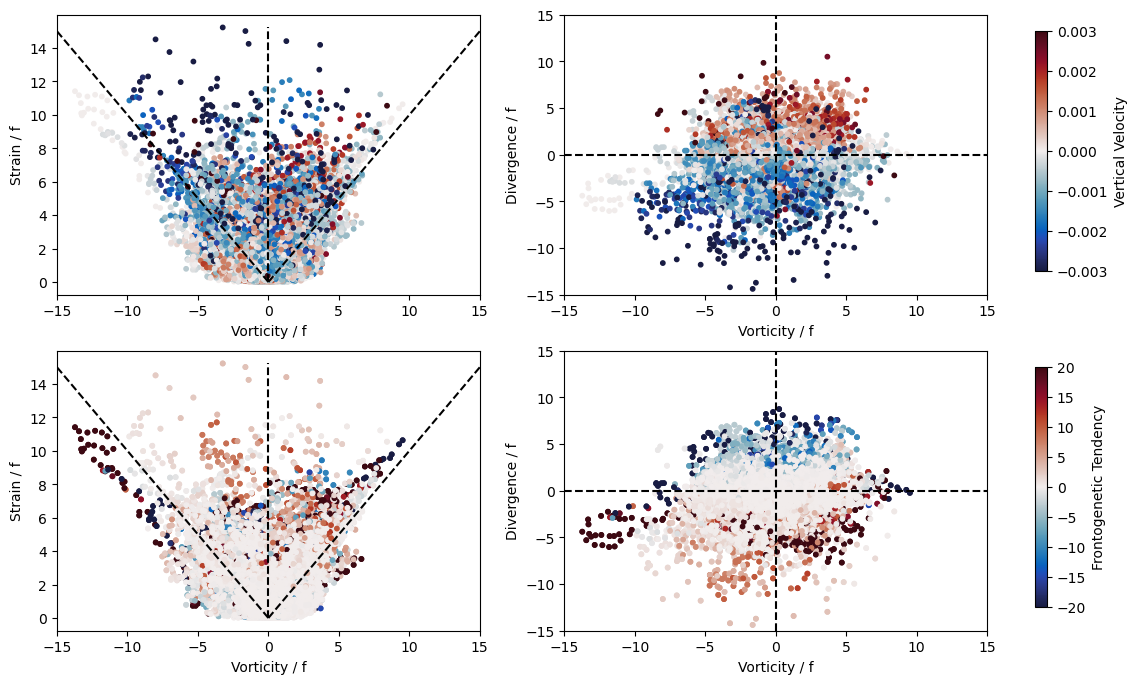

In [24]:
# subplots of:
# 1. strain vs. vorticity colored with vertical velocity 
# 2. divergence vs. vorticity colored with vertical velocity 
# 3. strain vs. vorticity colored with frontogenetic tendency 
# 4. divergence vs. vorticity colored with frontogenetic tendency 
subset = allcoefs.isel(depth=slice(0,24))

plt.rcParams.update({'font.size': 10})
xmin = -5 
xmax = 5
# subset = coefs.isel(depth=slice(0,24))
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
max = 15
min = -15

#parameters
kw = {'cmap':cmocean.cm.balance,
      'vmin':-0.003,
      'vmax':0.003}

# first subplot 
ax[0,0].scatter(subset.vort,subset.strain,c=subset.w,s=10,**kw)
ax[0,0].set_xlabel('Vorticity / f')
ax[0,0].set_ylabel('Strain / f')
ax[0,0].set_xlim(min,max)

# plot 1:1 lines 
x = subset.vort
y = subset.strain
ax[0,0].plot([0, max], [0, max], 'k',linestyle='dashed')
ax[0,0].plot([0, min], [0, -min], 'k',linestyle='dashed')
#plot vertical line at zero vorticity
ax[0,0].vlines(x=0,ymax=y.max(),ymin=0,color='k',linestyle='dashed')

#second subplot
im = ax[0,1].scatter(subset.vort,subset.div,c=subset.w,s=10,**kw)
ax[0,1].set_xlabel('Vorticity / f')
ax[0,1].set_ylabel('Divergence / f')
ax[0,1].set_ylim(min,max)
ax[0,1].set_xlim(min,max)
cbar_ax = fig.add_axes([0.94, 0.56, 0.010, 0.3])
fig.colorbar(im, cax=cbar_ax,label=r'Vertical Velocity')
ax[0,1].plot([min,max],[0,0],'--',color='k')
ax[0,1].plot([0,0],[min,max],'--',color='k')

kw = {'cmap':cmocean.cm.balance,'vmin':-20,'vmax':20}
# third subplot
ax[1,0].scatter(subset.vort,subset.strain,c=subset.F,s=10,**kw)
ax[1,0].scatter(subset.vort,subset.strain,c=subset.F,s=10,**kw)
ax[1,0].set_xlabel('Vorticity / f')
ax[1,0].set_ylabel('Strain / f')
ax[1,0].set_xlim(min,max)

# plot 1:1 lines 
x = subset.vort
y = subset.strain
ax[1,0].plot([0, max], [0, max], 'k',linestyle='dashed')
ax[1,0].plot([0, min], [0, -min], 'k',linestyle='dashed')
#plot vertical line at zero vorticity
ax[1,0].vlines(x=0,ymax=y.max(),ymin=0,color='k',linestyle='dashed')

# fourth subplot
im = ax[1,1].scatter(subset.vort,subset.div,c=subset.F,s=10,**kw)
im = ax[1,1].scatter(subset.vort,subset.div,c=subset.F,s=10,**kw)
ax[1,1].set_xlabel('Vorticity / f')
ax[1,1].set_ylabel('Divergence / f')
ax[1,1].set_ylim(min,max)
ax[1,1].set_xlim(min,max)
cbar_ax = fig.add_axes([0.94, 0.14, 0.010, 0.3])
fig.colorbar(im, cax=cbar_ax,label=r'Frontogenetic Tendency')
ax[1,1].plot([min,max],[0,0],'--',color='k')
ax[1,1].plot([0,0],[min,max],'--',color='k')

# plt.savefig('/shared/oceandynamics/Data/Atomic/DataMackenzie/FrontCaseStudy1/data/scatterplots_front1.jpeg',
#             dpi=200,bbox_inches='tight')
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/figures/paper_figs/FullDS_Scatterplots_upper50m.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)

In [25]:
# allcoefs['time'] = allcoefs.time.assign_attrs(long_name='time',
#                           units='Date to [ns]')

allcoefs['depth'] = allcoefs.depth.assign_attrs(long_name = 'Depth',
                            units='m')

allcoefs['v_mean'] = allcoefs.v_mean.assign_attrs(long_name = 'Mean v-velocity',
                             units = 'm/s')

allcoefs['vx'] = allcoefs.vx.assign_attrs(long_name = 'v-velocity x-gradient',
                         units = 's^-1')

allcoefs['vy'] = allcoefs.vy.assign_attrs(long_name='v-velocity y-gradient',
                         units='s^-1')

allcoefs['u_mean'] = allcoefs.u_mean.assign_attrs(long_name = 'Mean u-velocity',
                             units = 'm/s')

allcoefs['ux'] = allcoefs.ux.assign_attrs(long_name = 'u-velocity x-gradient',
                         units = 's^-1')

allcoefs['uy'] = allcoefs.uy.assign_attrs(long_name='u-velocity y-gradient',
                         units='s^-1')

allcoefs['e_mean'] = allcoefs.e_mean.assign_attrs(long_name = 'Mean velocity error',
                             units = 'm/s')

allcoefs['ex'] = allcoefs.ex.assign_attrs(long_name = 'velocity error x-gradient',
                         units = 's^-1')

allcoefs['ey']= allcoefs.ey.assign_attrs(long_name='velocity error y-gradient',
                         units='s^-1')

allcoefs['distance'] = allcoefs.distance.assign_attrs(long_name='Along track distance',
                         units='m')

allcoefs['vort'] = allcoefs.vort.assign_attrs(long_name='Normalized vorticity',
                         units='none')

allcoefs['div'] = allcoefs.div.assign_attrs(long_name='Normalized horizontal divergence',
                         units='none')

allcoefs['strain'] = allcoefs.strain.assign_attrs(long_name='Normalized lateral strain rate',
                         units='none')

allcoefs['w'] = allcoefs.w.assign_attrs(long_name='Vertical Velocity',
                         units='m/s',
                         description = 'vertical velocity calculated via downward integration of horizontal divergence')

allcoefs['F'] = allcoefs.F.assign_attrs(long_name='Normalized horizontal frontogenetic tendency',
                         units='none')



In [26]:
# allcoefs.to_netcdf('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/coefs_diagnostics.nc')


In [27]:
coefs_nonadcp['sal_mean'] = coefs_nonadcp.sal_mean.assign_attrs(long_name='Mean Salinity',
                                                                units = 'practical salinity units')

coefs_nonadcp['salx'] = coefs_nonadcp.salx.assign_attrs(long_name='salinity x-gradient',
                                                                units = 'practical salinity units')

coefs_nonadcp['saly'] = coefs_nonadcp.saly.assign_attrs(long_name='salinity y-gradient',
                                                                units = 'practical salinity units')

coefs_nonadcp['rho_mean'] = coefs_nonadcp.rho_mean.assign_attrs(long_name='Mean density',
                                                                units = 'kg/m^3')

coefs_nonadcp['rhox'] = coefs_nonadcp.rhox.assign_attrs(long_name='density x-gradient',
                                                                units = 'kg/m^4')

coefs_nonadcp['rhoy'] = coefs_nonadcp.rhoy.assign_attrs(long_name='density y-gradient',
                                                                units = 'kg/m^4')

coefs_nonadcp['t_mean'] = coefs_nonadcp.t_mean.assign_attrs(long_name='Mean temperature',
                                                                units = 'Degrees Celcius')

coefs_nonadcp['tx'] = coefs_nonadcp.tx.assign_attrs(long_name='temperature x-gradient',
                                                                units = 'Deg C / m')

coefs_nonadcp['ty'] = coefs_nonadcp.ty.assign_attrs(long_name='temperature y-gradient',
                                                                units = 'Deg C / m')

coefs_nonadcp['b_mean'] = coefs_nonadcp.b_mean.assign_attrs(long_name='Mean buoyancy',
                                                                units = 'm/s^2')

coefs_nonadcp['bx'] = coefs_nonadcp.bx.assign_attrs(long_name='buoyancy x-gradient',
                                                                units = 's^-2')

coefs_nonadcp['by'] = coefs_nonadcp.by.assign_attrs(long_name='buoyancy y-gradient',
                                                                units = 's^-2')

coefs_nonadcp['distance'] = coefs_nonadcp.distance.assign_attrs(long_name='Along track distance',
                                                                units = 'm')

coefs_nonadcp['rho_mag'] = coefs_nonadcp.rho_mag.assign_attrs(long_name='Magnitude of Density Gradient',
                                                                units = 'kg/m^4')

coefs_nonadcp['rho_angle'] = coefs_nonadcp.rho_angle.assign_attrs(long_name='Density Gradient Angle Relative to SD track',
                                                                units = 'degrees',
                                                                description='Angle calculated via arc tangent of rhoy and rhox')


In [29]:
# coefs_nonadcp.to_netcdf('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/coefs_nonadcp_diagnostics.nc')

### Figures 

In [30]:
import matplotlib as mpl

In [31]:
FT_masked = np.ma.masked_array(subset.F.isel(depth=0), [(-1 <= subset.F.isel(depth=0)) & (subset.F.isel(depth=0) <= 1)])

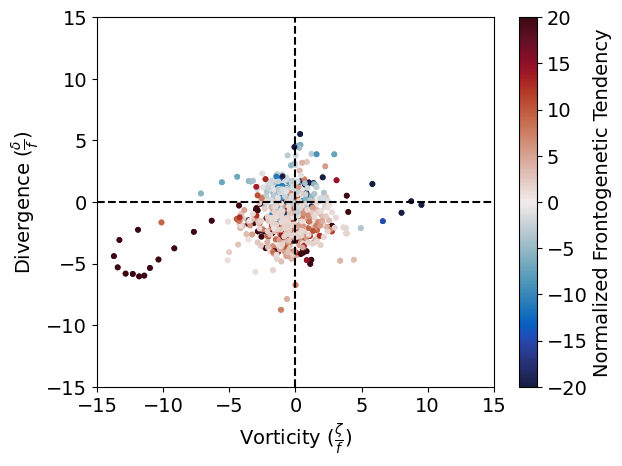

In [32]:
# fourth subplot
plt.rcParams.update({'font.size': 14})
xmin = -5 
xmax = 5
kw = {'cmap':cmocean.cm.balance,'vmin':-20,'vmax':20}
plt.scatter(subset.vort.isel(depth=0),subset.div.isel(depth=0),c=FT_masked,s=10,**kw)
plt.scatter(subset.vort.isel(depth=0),subset.div.isel(depth=0),c=FT_masked,s=10,**kw)
plt.xlabel(r'Vorticity $(\frac{\zeta}{f})$')
plt.ylabel(r'Divergence $(\frac{\delta}{f})$')
plt.ylim(min,max)
plt.xlim(min,max)
# cbar_ax = fig.add_axes([0.94, 0.14, 0.010, 0.3])
plt.colorbar(label=r'Normalized Frontogenetic Tendency')
plt.plot([min,max],[0,0],'--',color='k')
plt.plot([0,0],[min,max],'--',color='k')

# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/FT_scatter.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)
            

(-10.0, 10.0)

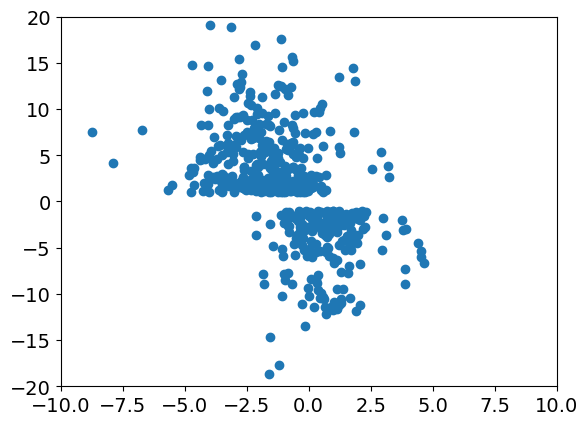

In [33]:
plt.scatter(subset.div.isel(depth=0),FT_masked,vmin=-20,vmax=20)
plt.ylim(-20,20)
plt.xlim(-10,10)

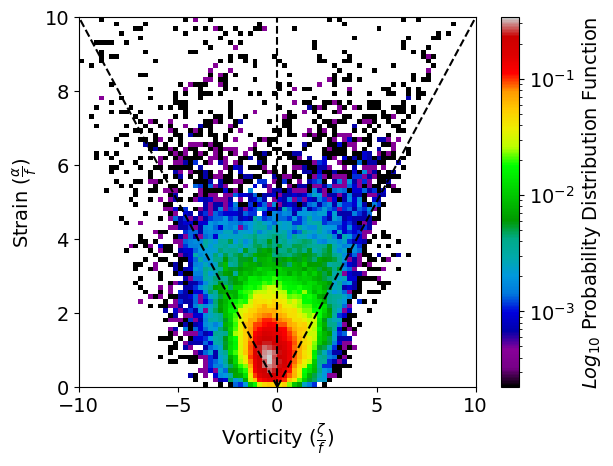

In [34]:
dbins, bmin, bmax = 0.25, -10, 10
subset = allcoefs.isel(depth=slice(0,24))
binsx=np.arange(bmin,bmax+dbins,dbins)
binsy=np.arange(bmin,bmax+dbins,dbins)
bins_s=np.arange(0,bmax+dbins/2,dbins/2)
plt.hist2d(subset.vort.values.flatten(),subset.strain.values.flatten(),bins=[binsx,bins_s],density=True,cmap='nipy_spectral',
          norm=mpl.colors.LogNorm())

# plot 1:1 lines 
x = subset.vort
y = subset.strain
plt.plot([0, bmax], [0, bmax], 'k',linestyle='dashed')
plt.plot([0, bmin], [0, -bmin], 'k',linestyle='dashed')
#plot vertical line at zero vorticity
plt.vlines(x=0,ymax=y.max(),ymin=0,color='k',linestyle='dashed')

plt.xlabel(r'Vorticity $(\frac{\zeta}{f})$')
plt.ylabel(r'Strain $(\frac{\alpha}{f})$')
plt.colorbar(label=r'$Log_{10}$ Probability Distribution Function')
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/strain_vort_JPDF.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)
            

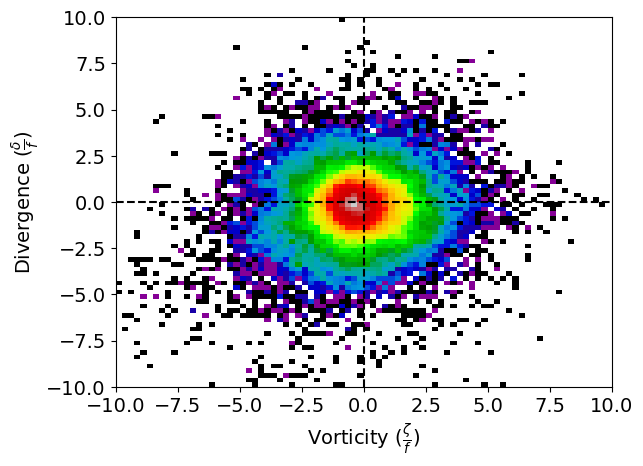

In [35]:
fig, ax = plt.subplots()
my_cmap = cmap = plt.cm.get_cmap("Spectral_r").copy()
# my_cmap.set_under('w',0.001)
dbins, bmin, bmax = 0.25, -10, 10
subset = allcoefs.isel(depth=slice(0,24))
binsx=np.arange(bmin,bmax+dbins,dbins)
binsy=np.arange(bmin,bmax+dbins,dbins)
bins_s=np.arange(0,bmax+dbins/2,dbins/2)
plt.hist2d(subset.vort.values.flatten(),subset.div.values.flatten(),bins=[binsx,binsy],density=True,cmap='nipy_spectral',
          norm=mpl.colors.LogNorm())
ax.set_facecolor("white")
# plt.colorbar(label=r'$Log_{10}$ Probability Distribution Function')
ax.set_facecolor("white")
plt.plot([bmin,bmax],[0,0],'--',color='k')
plt.plot([0,0],[bmin,bmax],'--',color='k')
plt.xlabel(r'Vorticity $(\frac{\zeta}{f})$')
plt.ylabel(r'Divergence $(\frac{\delta}{f})$')
plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/vort_div_JPDF.png',
            dpi=400,
            bbox_inches='tight',
            transparent=True)

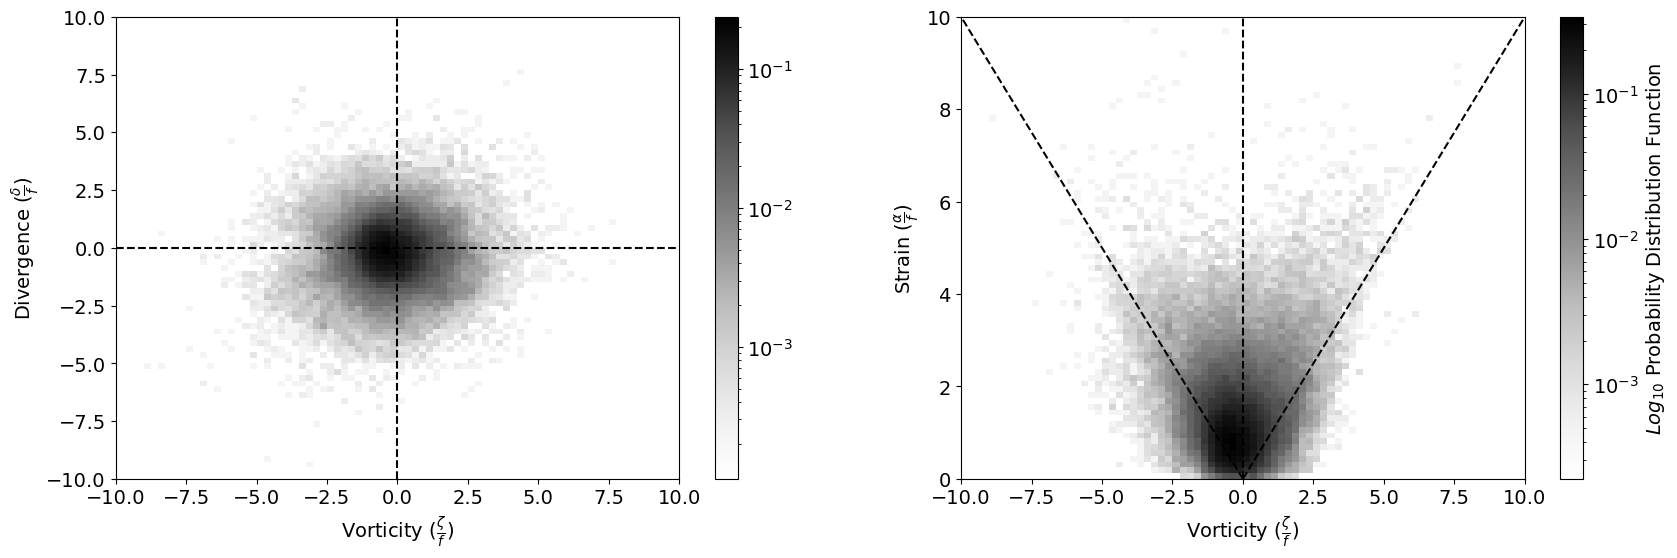

In [39]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
my_cmap = cmap = plt.cm.get_cmap("Spectral_r").copy()
# my_cmap.set_under('w',0.001)
dbins, bmin, bmax = 0.25, -10, 10
subset = allcoefs.isel(depth=slice(0,24))
binsx=np.arange(bmin,bmax+dbins,dbins)
binsy=np.arange(bmin,bmax+dbins,dbins)
bins_s=np.arange(0,bmax+dbins/2,dbins/2)
im = ax[0].hist2d(subset.vort.values.flatten(),subset.div.values.flatten(),bins=[binsx,binsy],density=True,cmap='Greys',
          norm=mpl.colors.LogNorm())
# ax.set_facecolor("white")
# cbar_ax = fig.add_axes([0.94, 0.14, 0.010, 0.3])
plt.colorbar(im[3],ax=ax[0])
# ax.set_facecolor("white")
ax[0].plot([bmin,bmax],[0,0],'--',color='k')
ax[0].plot([0,0],[bmin,bmax],'--',color='k')
ax[0].set_xlabel(r'Vorticity $(\frac{\zeta}{f})$')
ax[0].set_ylabel(r'Divergence $(\frac{\delta}{f})$')


im = ax[1].hist2d(subset.vort.values.flatten(),subset.strain.values.flatten(),bins=[binsx,bins_s],density=True,cmap='Greys',
          norm=mpl.colors.LogNorm())

# plot 1:1 lines 
x = subset.vort
y = subset.strain
ax[1].plot([0, bmax], [0, bmax], 'k',linestyle='dashed')
ax[1].plot([0, bmin], [0, -bmin], 'k',linestyle='dashed')
#plot vertical line at zero vorticity
ax[1].vlines(x=0,ymax=y.max(),ymin=0,color='k',linestyle='dashed')

ax[1].set_xlabel(r'Vorticity $(\frac{\zeta}{f})$')
ax[1].set_ylabel(r'Strain $(\frac{\alpha}{f})$')
plt.colorbar(im[3],label=r'$Log_{10}$ Probability Distribution Function',ax=ax[1])

# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/JPDF.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)
            

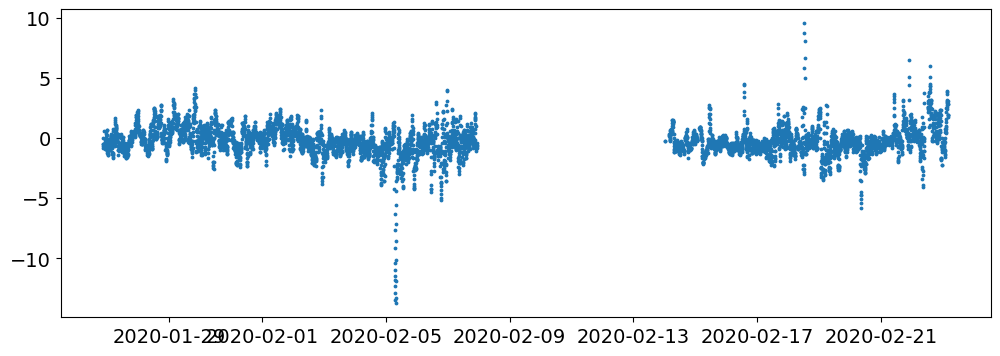

In [37]:
fig = plt.figure(figsize=(12,4))
plt.scatter(allcoefs.time,allcoefs.vort.isel(depth=0),s=3)

### Manuscript Figure. 7 

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_54120/109032335.py:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax[0].hist2d(subset.vort.values.flatten(),subset.div.values.flatten(),bins=[binsx,binsy],density=True,cmap=cmocean.cm.dense,
/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_54120/109032335.py:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax[1].hist2d(subset.vort.values.flatten(),subset.strain.values.flatten(),bins=[binsx,bins_s],density=True,cmap=cmocean.cm.dense,


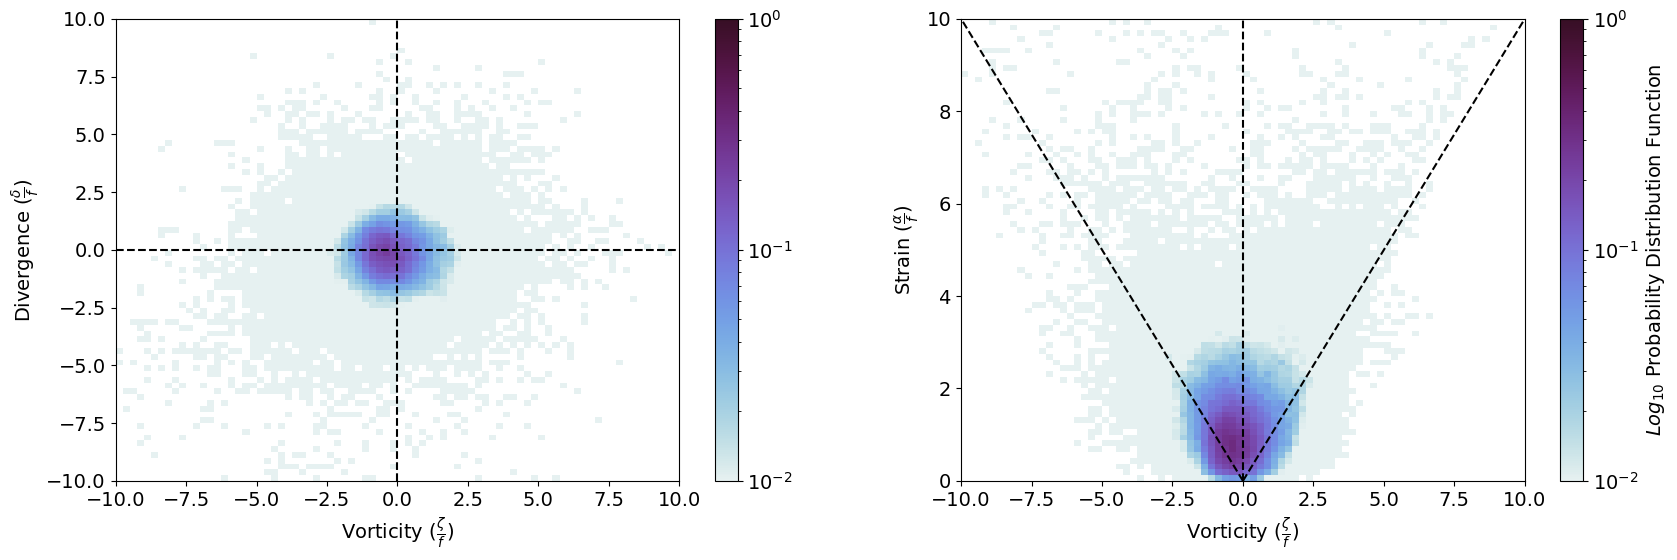

In [38]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
# my_cmap = cmap = plt.cm.get_cmap("Spectral_r").copy()
# my_cmap.set_under('w',0.001)
dbins, bmin, bmax = 0.25, -10, 10
subset = allcoefs.isel(depth=slice(0,24))
binsx=np.arange(bmin,bmax+dbins,dbins)
binsy=np.arange(bmin,bmax+dbins,dbins)
bins_s=np.arange(0,bmax+dbins/2,dbins/2)
ax[0].hist2d(subset.vort.values.flatten(),subset.div.values.flatten(),bins=[binsx,binsy],density=True,cmap=cmocean.cm.dense,
          norm=mpl.colors.LogNorm(),vmin=10e-3,vmax=10e-1)
# ax.set_facecolor("white")
# cbar_ax = fig.add_axes([0.94, 0.14, 0.010, 0.3])
# plt.colorbar(im[3],ax=ax[0])
# ax.set_facecolor("white")
ax[0].plot([bmin,bmax],[0,0],'--',color='k')
ax[0].plot([0,0],[bmin,bmax],'--',color='k')
ax[0].set_xlabel(r'Vorticity $(\frac{\zeta}{f})$')
ax[0].set_ylabel(r'Divergence $(\frac{\delta}{f})$')


im = ax[1].hist2d(subset.vort.values.flatten(),subset.strain.values.flatten(),bins=[binsx,bins_s],density=True,cmap=cmocean.cm.dense,
          norm=mpl.colors.LogNorm(),vmin=10e-3,vmax=10e-1)

# plot 1:1 lines 
x = subset.vort
y = subset.strain
ax[1].plot([0, bmax], [0, bmax], 'k',linestyle='dashed')
ax[1].plot([0, bmin], [0, -bmin], 'k',linestyle='dashed')
#plot vertical line at zero vorticity
ax[1].vlines(x=0,ymax=y.max(),ymin=0,color='k',linestyle='dashed')

ax[1].set_xlabel(r'Vorticity $(\frac{\zeta}{f})$')
ax[1].set_ylabel(r'Strain $(\frac{\alpha}{f})$')
plt.colorbar(im[3],label=r'$Log_{10}$ Probability Distribution Function',ax=ax[1])
plt.colorbar(im[3],ax=ax[0])

# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/JPDF.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)
